In [1]:
# setup
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import scipy.integrate

In [2]:
# setup: has to be in a separate cell for some reason
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
# from last time
def run_sim(N0, gen_fn, ngens, dtype='int', **kwargs):
    """
    Runs some simulations, and return the results in the columns of an array.
    
    N0: initial conditions for the simulations
    gen_fn: the function that takes the current array of population sizes and some more arguments,
        and returns the array of population sizes in the next time step
    ngens: number of time steps to run the simulations for
    dtype: the numeric type of the result (defaults to integers)
    **kwargs: more arguments passed to `gen_fn()`
    
    returns: A (ngens, len(N0)) array of type `dtype`.
    """
    N = np.empty((ngens, len(N0)), dtype=dtype)
    N[0, :] = N0
    for t in range(1, ngens):
        N[t, :] = gen_fn(N[t-1, :], **kwargs)
    return N

# Differential equation models

Today we'll look at *differential equation* models,
which are

1. deterministic (not random), and
2. continuous-time.

Both of these are approximations, at least at some level,
but provide a very useful big-picture look at how a model "ought to behave".

## The logistic model

Last time we studied a model of *logistic population growth*.
Reparameterizing a bit,
in this model the population size at time step $k$, denoted $N_k$,
satisfies
$$\begin{aligned}
  N_{k+1} - N_k &= N_k \left( \lambda - \mu - \frac{\lambda N_k}{K} \right) + \epsilon,
\end{aligned}$$
where

- $\mu$ is the probability an individual dies before to the next time step,
- $\lambda$ is the mean unconstrainted number of offspring per time step,
- $K$ is the "carrying capacity", and
- $\epsilon$ is "noise", with mean zero and variance proportional to the number of births and deaths.

Imagine our first model was very coarse-grained:
we'd defined one "time step" to be 100 years,
and now we want to refine it, using the "same" model,
but with one time step equal to *one* year.
To do this, we'd need to:

- divide $\mu$ by 100 (so the mean number of deaths per 100 years would be the same), and
- divide $\lambda$ by 100 (same, for births).

The carrying capacity would stay the same, 
and the variance of $\epsilon$ would decrease 
along with the number of births and deaths per time step.

Let's say instead that one original time step is one "unit of time", 
that we now break up into $T$ time steps.
Then, the equation above is:
$$\begin{aligned}
  N_{t+1/T} - N_t &= \frac{1}{T} N_t \left( \lambda - \mu - \frac{\lambda N_t}{K} \right) + \epsilon .
\end{aligned}$$

The first idea of how this should behave comes from by ignoring noise
(setting $\epsilon = 0$).
Then, multiplying by $T$ and taking $T \to \infty$
(the limit of small time steps),
we end up with the *logistic equation*,
$$\begin{aligned}
  \frac{d}{dt} N_t &= N_t \left( \lambda - \mu - \frac{\lambda N_t}{K} \right).
\end{aligned}$$
(Well, it's the logistic equation we'd find [on Wikipedia](https://en.wikipedia.org/wiki/Logistic_function#Applications)
if we set $r = \lambda - \mu$ and change $K$ to $K r / \lambda$.)

$$ \frac{d}{dt} f(t) = \lim_{\epsilon \to 0} \frac{1}{\epsilon} (f(t + \epsilon) - f(t)) $$

**Solving differential equations**
can be done with [`scipy.integrate`](https://docs.scipy.org/doc/scipy/reference/integrate.html).
How's this differ from iterating the discrete, deterministic equation?
Not much, in this case.

In [4]:
lam = 0.1
mu = 1 - 0.95
K = 2000
def logistic_eqn(t, y):
    return y * (lam - mu - lam * y / K)
    
y0 = np.array([0.6, 0.8, 1.0, 1.2, 1.4]) * K / 2
logistic_solns = scipy.integrate.solve_ivp(
                      fun = logistic_eqn, 
                      t_span = (0.0, 120.0),
                      y0 = y0,
                      t_eval=range(121))

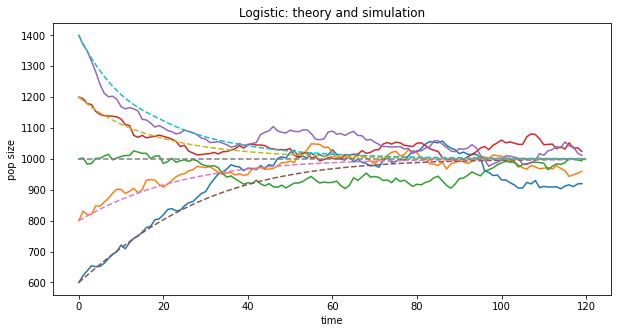

In [5]:
def logistic_gen(N, lam, mu, K):
    return (np.random.poisson(lam * N * np.fmax(0.0, 1 - N / K), len(N)) 
            + np.random.binomial(N, 1 - mu, len(N)))


N = run_sim(y0, 
            gen_fn=logistic_gen, ngens=120, 
            lam=lam, mu=mu, K=K)

plt.plot(N)
plt.plot(logistic_solns.y.T, linestyle='--')
plt.xlabel("time")
plt.ylabel("pop size")
plt.title("Logistic: theory and simulation")
plt.show()

In [6]:
help(scipy.integrate.solve_ivp)

Help on function solve_ivp in module scipy.integrate._ivp.ivp:

solve_ivp(fun, t_span, y0, method='RK45', t_eval=None, dense_output=False, events=None, vectorized=False, args=None, **options)
    Solve an initial value problem for a system of ODEs.
    
    This function numerically integrates a system of ordinary differential
    equations given an initial value::
    
        dy / dt = f(t, y)
        y(t0) = y0
    
    Here t is a 1-D independent variable (time), y(t) is an
    N-D vector-valued function (state), and an N-D
    vector-valued function f(t, y) determines the differential equations.
    The goal is to find y(t) approximately satisfying the differential
    equations, given an initial value y(t0)=y0.
    
    Some of the solvers support integration in the complex domain, but note
    that for stiff ODE solvers, the right-hand side must be
    complex-differentiable (satisfy Cauchy-Riemann equations [11]_).
    To solve a problem in the complex domain, pass y0 with a co

### Exercise

Compare the solution to the differential equation
to iteration of the deterministic equation we had before:

In [ ]:
def logistic_step(N, lam, mu, K):
    return N + (lam - mu) * N * (1 - lam * N / (K * (lam - mu)))